Correlation matrix of first 7 features (should be highly correlated):
          X1        X2        X3        X4        X5        X6        X7
X1  1.000000  0.997524  0.997305  0.997398  0.997463  0.997367  0.997388
X2  0.997524  1.000000  0.997445  0.997420  0.997456  0.997490  0.997447
X3  0.997305  0.997445  1.000000  0.997341  0.997389  0.997441  0.997420
X4  0.997398  0.997420  0.997341  1.000000  0.997542  0.997484  0.997449
X5  0.997463  0.997456  0.997389  0.997542  1.000000  0.997450  0.997370
X6  0.997367  0.997490  0.997441  0.997484  0.997450  1.000000  0.997480
X7  0.997388  0.997447  0.997420  0.997449  0.997370  0.997480  1.000000

Dataset shape: (2000, 10)
Number of samples: 2000
Number of features: 10

Testing different learning rates and regularization parameters...

Top 10 models sorted by R² score:
       lr     alpha        r2       mse  final_cost  n_iters
30  0.100  10.00000  0.999541  0.242785    0.354389     2409
22  0.010  10.00000  0.999541  0.242992    0.354

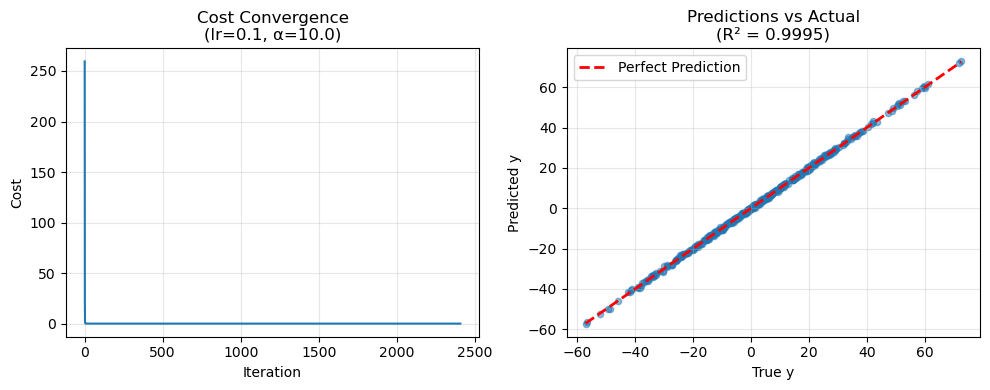


Learned Coefficients:
Bias (w₀): 0.6683
  w1: 3.2693
  w2: 3.2145
  w3: 3.3037
  w4: 3.3747
  w5: 3.0419
  w6: 3.2505
  w7: 3.3128
  w8: 0.4901
  w9: -0.1945
  w10: 0.0007


In [20]:
"""
Q1: Generate a dataset with ≥7 highly correlated columns and implement 
Ridge Regression with Gradient Descent, test learning rates and regularization 
parameters, pick best by minimizing cost and maximizing R²
"""

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)


n = 2000


x0 = np.random.normal(0, 1, size=n)


X_correlated = np.column_stack([x0 + np.random.normal(0, 0.05, size=n) for _ in range(7)])


X_extra = np.column_stack([np.random.normal(0, 1, size=n) for _ in range(3)])
X = np.hstack([X_correlated, X_extra])


true_coefs = np.array([3.5, 3.1, 3.2, 3.4, 3.0, 3.3, 3.6, 0.5, -0.2, 0.0])
y = X.dot(true_coefs) + np.random.normal(0, 0.5, size=n)


cols = [f"X{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=cols)
df['y'] = y

print("Correlation matrix of first 7 features (should be highly correlated):")
print(df[cols[:7]].corr())
print("\nDataset shape:", X.shape)
print("Number of samples:", n)
print("Number of features:", X.shape[1])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


mean_X = X_train.mean(axis=0)
std_X = X_train.std(axis=0, ddof=0)
X_train_s = (X_train - mean_X) / std_X
X_test_s = (X_test - mean_X) / std_X


def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

Xtr = add_bias(X_train_s)
Xte = add_bias(X_test_s)


def ridge_cost_and_grad(w, X, y, alpha):
    """Compute Ridge Regression cost and gradient"""
    n = X.shape[0]
    preds = X.dot(w)
    residuals = preds - y
    
    
    mse = (1/(2*n)) * np.sum(residuals**2)
    reg = (alpha/(2*n)) * np.sum(w[1:]**2)
    cost = mse + reg
    
 
    grad = (1/n) * (X.T.dot(residuals))
    grad[1:] += (alpha/n) * w[1:]
    
    return cost, grad

def ridge_gd(X, y, alpha, lr, n_iters=5000, tol=1e-8, verbose=False):
    """
    Ridge Regression using Gradient Descent
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Training data
    y : array-like, shape (n_samples,)
        Target values
    alpha : float
        Regularization parameter
    lr : float
        Learning rate
    n_iters : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
    verbose : bool
        Whether to print convergence info
    """
    n, d = X.shape
    w = np.zeros(d)
    costs = []
    
    for it in range(n_iters):
        cost, grad = ridge_cost_and_grad(w, X, y, alpha)
        w -= lr * grad
        costs.append(cost)
        
      
        if it > 0 and abs(costs[-1] - costs[-2]) < tol:
            if verbose:
                print(f"Converged at iteration {it+1}")
            break
    
    return w, costs

print("\n" + "="*70)
print("Testing different learning rates and regularization parameters...")
print("="*70)

lr_list = [0.0001, 0.001, 0.01, 0.1, 1]
alpha_list = [0, 1e-5, 1e-3, 0.01, 0.1, 1, 10, 100]

results = []
for lr in lr_list:
    for alpha in alpha_list:
        try:
            w, costs = ridge_gd(Xtr, y_train, alpha=alpha, lr=lr)
            y_pred_test = Xte.dot(w)
            r2 = r2_score(y_test, y_pred_test)
            mse = mean_squared_error(y_test, y_pred_test)
            final_cost = costs[-1]
            results.append({
                'lr': lr, 
                'alpha': alpha, 
                'r2': r2, 
                'mse': mse, 
                'final_cost': final_cost, 
                'n_iters': len(costs)
            })
        except Exception as e:
            
            continue


res_df = pd.DataFrame(results)


print("\nTop 10 models sorted by R² score:")
print("="*70)
print(res_df.sort_values('r2', ascending=False).head(10).to_string())
print("="*70)


best = res_df.sort_values('r2', ascending=False).iloc[0]
best_lr = best['lr']
best_alpha = best['alpha']
best_r2 = best['r2']
best_mse = best['mse']

print(f"\nBest Model:")
print(f"  Learning Rate (lr): {best_lr}")
print(f"  Regularization (alpha): {best_alpha}")
print(f"  R² Score: {best_r2:.4f}")
print(f"  MSE: {best_mse:.4f}")


print("\nTraining best model and generating visualizations...")
w_best, costs_best = ridge_gd(Xtr, y_train, alpha=best_alpha, lr=best_lr, verbose=True)


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(costs_best)
plt.title(f'Cost Convergence\n(lr={best_lr}, α={best_alpha})')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
y_pred = Xte.dot(w_best)
plt.scatter(y_test, y_pred, s=20, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True y')
plt.ylabel('Predicted y')
plt.title(f'Predictions vs Actual\n(R² = {r2_score(y_test, y_pred):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\nLearned Coefficients:")
print(f"Bias (w₀): {w_best[0]:.4f}")
for i in range(1, len(w_best)):
    print(f"  w{i}: {w_best[i]:.4f}")


---

## Q2: Hitters Dataset - Load, Preprocess, Train Multiple Models

Load the Hitters dataset, preprocess (handle missing values, encode categorical variables, scale features), train multiple regression models, and evaluate their performance.

**Requirements:**
- (a) Pre-process the data (null values, noise, categorical to numerical encoding)
- (b) Separate input and output features and perform scaling  
- (c) Fit Linear, Ridge (α=0.5748), and LASSO (α=0.5748) regression models
- (d) Evaluate the performance of each trained model on test set


In [19]:
"""
Q2: Load Hitters dataset, preprocess, encode, scale, train multiple models and evaluate
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


print("="*70)
print("Q2: Loading Hitters Dataset")
print("="*70)

try:
    import gdown
    file_id = "1qzCKF6JKKMB0p7ul_lLy8tdmRk3vE_bG"
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    gdown.download(url, "Hitters.csv", quiet=False)
    print("\n✓ Dataset downloaded successfully!")
except Exception as e:
    print(f"\n⚠ Download error: {e}")
    print("Please manually download the dataset from the provided link.")


try:
    df = pd.read_csv("Hitters.csv")
    print(f"✓ Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
except FileNotFoundError:
    print("⚠ Hitters.csv not found. Please ensure the file is in the current directory.")
    df = None

if df is not None:
   
    print("\n" + "="*70)
    print("Dataset Information")
    print("="*70)
    print(f"\nColumn names: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nStatistical summary:")
    print(df.describe())


Q2: Loading Hitters Dataset

⚠ Download error: No module named 'gdown'
Please manually download the dataset from the provided link.
⚠ Hitters.csv not found. Please ensure the file is in the current directory.


In [17]:

if df is not None:
    
    target_col = 'Salary'
    
    if target_col not in df.columns:
        print(f"\n⚠ Warning: '{target_col}' column not found.")
        print(f"Available columns: {df.columns.tolist()}")
        print("Please specify the correct target column name.")
    else:
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        print("\n" + "="*70)
        print("Part (a): Data Preprocessing")
        print("="*70)
        
      
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        
        print(f"\nCategorical columns: {categorical_cols}")
        print(f"Numerical columns: {numerical_cols}")
        
       
        print("\n1. Handling missing values in features...")
        imputer_num = SimpleImputer(strategy='median')
        X[numerical_cols] = imputer_num.fit_transform(X[numerical_cols])
        
        if len(categorical_cols) > 0:
            imputer_cat = SimpleImputer(strategy='most_frequent')
            X[categorical_cols] = imputer_cat.fit_transform(X[categorical_cols])
        
      
        valid_mask = ~y.isnull()
        X = X[valid_mask].copy()
        y = y[valid_mask].copy()
        
        print(f"After handling missing values: X shape = {X.shape}, y shape = {y.shape}")
        
       
        print("\n2. Encoding categorical variables...")
        label_encoders = {}
        for col in categorical_cols:
            if col in X.columns:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                label_encoders[col] = le
                print(f"  ✓ Encoded '{col}': {len(le.classes_)} unique values")
        
        
        print("\n3. Splitting data into train and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        print(f"  Training set: {X_train.shape}")
        print(f"  Test set: {X_test.shape}")
        
        print("\n4. Scaling features using StandardScaler...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
       
        feature_names = X_train.columns.tolist()
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)
        
        print("  ✓ Features scaled successfully")
        print("\n✓ Preprocessing completed!")
        print("="*70)
    
else:
    print("\nDataset not loaded. Please run the previous cell first.")
    X_train_scaled = None
    X_test_scaled = None
    y_train = None
    y_test = None
    feature_names = None



Dataset not loaded. Please run the previous cell first.


In [18]:
# Part (c) & (d): Train Linear, Ridge, and Lasso models and evaluate performance
if X_train_scaled is not None and y_train is not None:
    print("\n" + "="*70)
    print("Part (c): Training Linear, Ridge (α=0.5748), and LASSO (α=0.5748) Models")
    print("="*70)
    
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge (α=0.5748)': Ridge(alpha=0.5748),
        'Lasso (α=0.5748)': Lasso(alpha=0.5748)
    }
    
 
    results = []
    trained_models = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
      
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model
        
     
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
       
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        results.append({
            'Model': name,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train MAE': train_mae,
            'Test MAE': test_mae
        })
        
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
        print(f"  Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
    
   
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*70)
    print("Part (d): Model Comparison Results")
    print("="*70)
    print(results_df.to_string(index=False))
    
  
    best_idx = results_df['Test R²'].idxmax()
    best_model_name = results_df.loc[best_idx, 'Model']
    best_model = trained_models[best_model_name]
    
    print("\n" + "="*70)
    print(f"Best Model: {best_model_name}")
    print(f"  Test R²: {results_df.loc[best_idx, 'Test R²']:.4f}")
    print(f"  Test MSE: {results_df.loc[best_idx, 'Test MSE']:.2f}")
    print(f"  Test MAE: {results_df.loc[best_idx, 'Test MAE']:.2f}")
    print("="*70)
    
    # Visualizations
    print("\nGenerating visualizations...")
    fig = plt.figure(figsize=(16, 5))
    
    # 1. Model comparison - R² Score
    plt.subplot(1, 3, 1)
    x_pos = np.arange(len(results_df))
    plt.bar(x_pos - 0.2, results_df['Train R²'], 0.4, label='Train R²', alpha=0.7)
    plt.bar(x_pos + 0.2, results_df['Test R²'], 0.4, label='Test R²', alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.title('Model Performance Comparison (R² Score)')
    plt.xticks(x_pos, results_df['Model'], rotation=15, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # 2. Model comparison - MSE
    plt.subplot(1, 3, 2)
    plt.bar(x_pos - 0.2, results_df['Train MSE'], 0.4, label='Train MSE', alpha=0.7)
    plt.bar(x_pos + 0.2, results_df['Test MSE'], 0.4, label='Test MSE', alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('MSE')
    plt.title('Model Performance Comparison (MSE)')
    plt.xticks(x_pos, results_df['Model'], rotation=15, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # 3. Predictions vs Actual for best model
    plt.subplot(1, 3, 3)
    y_test_pred_best = best_model.predict(X_test_scaled)
    plt.scatter(y_test, y_test_pred_best, alpha=0.6, s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Best Model: {best_model_name}\nTest R² = {results_df.loc[best_idx, "Test R²"]:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("Analysis Summary")
    print("="*70)
    print("\nWhich model performs best and Why?")
    print(f"\nThe best performing model is {best_model_name} with:")
    print(f"  • Test R² Score: {results_df.loc[best_idx, 'Test R²']:.4f} (closer to 1 is better)")
    print(f"  • Test MSE: {results_df.loc[best_idx, 'Test MSE']:.2f} (lower is better)")
    print(f"  • Test MAE: {results_df.loc[best_idx, 'Test MAE']:.2f} (lower is better)")
    print("\nRegularization helps prevent overfitting by:")
    print("  • Ridge (L2): Shrinks coefficients towards zero")
    print("  • Lasso (L1): Forces some coefficients to exactly zero (feature selection)")
    print("\n✓ Q2 Analysis Complete!")
    print("="*70)
    
else:
    print("\n⚠ Error: Dataset not properly loaded or preprocessed.")
    print("Please run the previous cells first.")



⚠ Error: Dataset not properly loaded or preprocessed.
Please run the previous cells first.


---

## Q3: Cross Validation for Ridge and Lasso Regression

Explore Ridge Cross Validation (RidgeCV) and Lasso Cross Validation (LassoCV) functions from sklearn. Implement both on the Boston House Prediction Dataset.

**Objective:**
- Load the Boston Housing dataset from sklearn.datasets
- Use RidgeCV to find optimal ridge regularization parameter
- Use LassoCV to find optimal lasso regularization parameter
- Compare the performance of both models


Q3: Cross Validation for Ridge and Lasso Regression

1. Loading Boston Housing dataset from OpenML...
   Dataset shape: (506, 13)
   Target shape: (506,)
   Feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']

2. Splitting data into train and test sets...
   Training set: (404, 13)
   Test set: (102, 13)

3. Scaling features using StandardScaler...
   ✓ Features scaled successfully

4. Testing alpha values from 0.0001 to 100.00
   Total alpha values: 50

Training RidgeCV Model

✓ RidgeCV training completed!
   Optimal alpha: 2.5595

Training LassoCV Model

✓ LassoCV training completed!
   Optimal alpha: 0.0001
   Number of iterations: 77

5. Making predictions on test set...

Model Performance Comparison
  Metric   RidgeCV   LassoCV
R² Score  0.668001  0.668755
     MSE 24.346743 24.291456
     MAE  3.181994  3.188999

Best Model: LassoCV
Test R² Score: 0.6688

6. Generating visualizations...


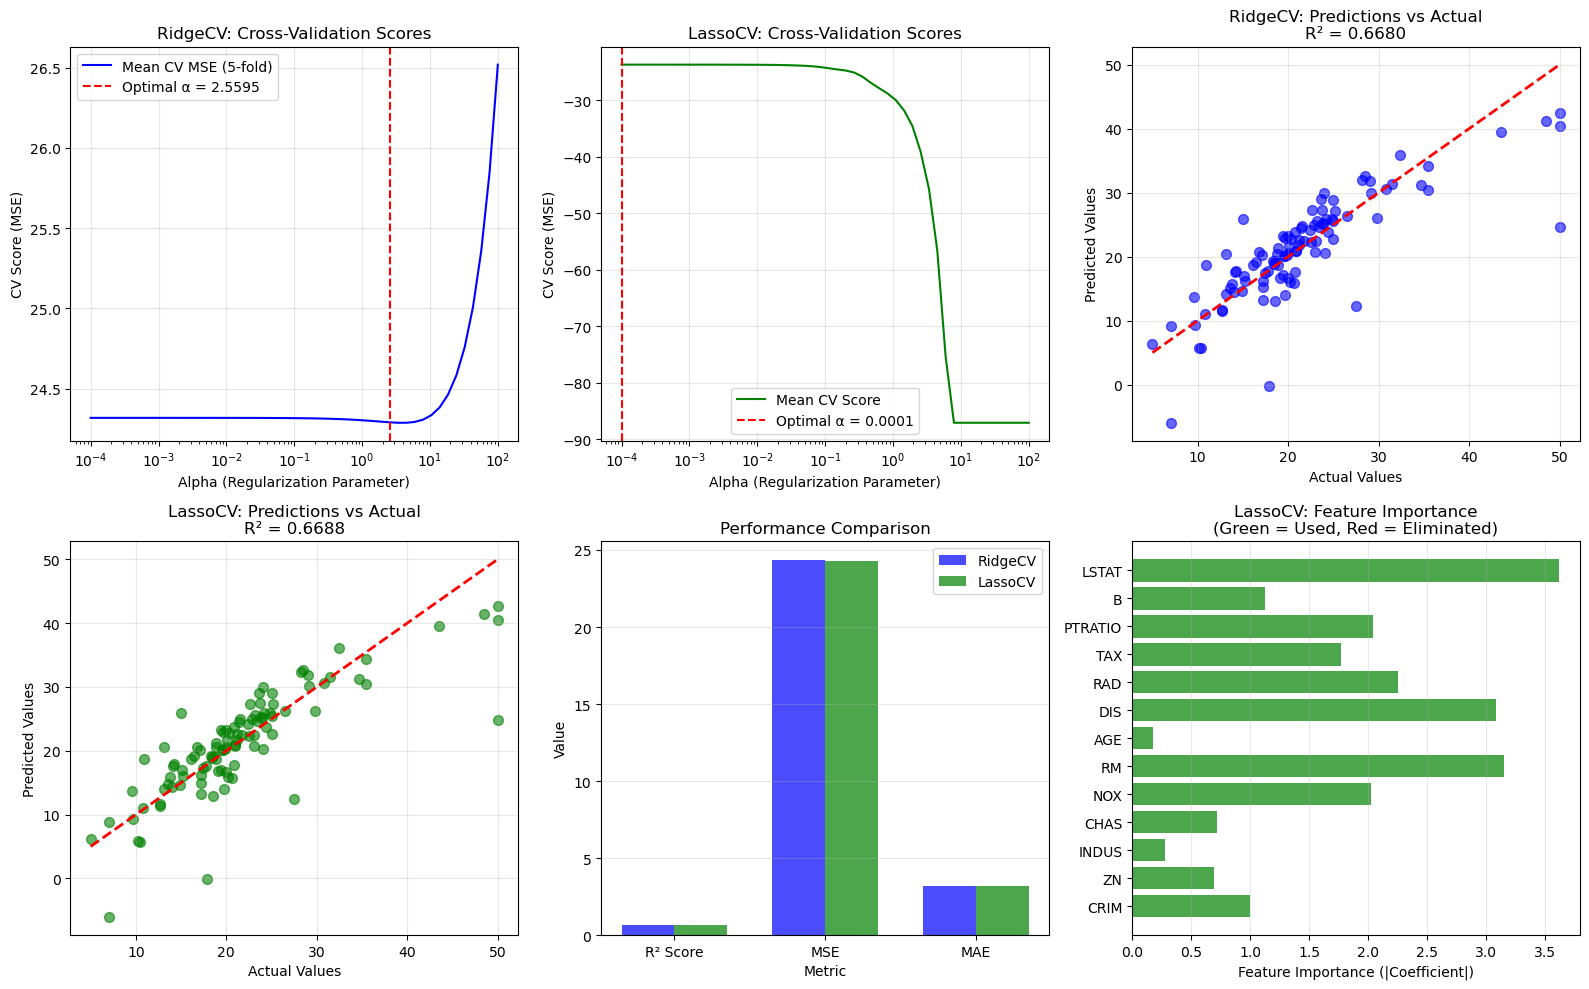


Summary
RidgeCV:
  • Optimal α: 2.5595
  • Test R²: 0.6680
  • Test MSE: 24.35
  • All features retained: True

LassoCV:
  • Optimal α: 0.0001
  • Test R²: 0.6688
  • Test MSE: 24.29
  • Features eliminated: 0/13

✓ Q3 Analysis Complete!


In [14]:
"""
Q3: Cross Validation for Ridge and Lasso Regression
Implement RidgeCV and LassoCV on Boston House Prediction Dataset
"""

# Import necessary libraries
from sklearn.datasets import fetch_openml
from sklearn.linear_model import RidgeCV, LassoCV, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("Q3: Cross Validation for Ridge and Lasso Regression")
print("="*70)


print("\n1. Loading Boston Housing dataset from OpenML...")
boston = fetch_openml(name='boston', version=1, as_frame=True)
X = boston.data.values
y = boston.target.values.astype(float)
feature_names = np.array(boston.feature_names) if hasattr(boston, 'feature_names') else np.array(boston.data.columns.tolist())

print(f"   Dataset shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Feature names: {feature_names}")


print("\n2. Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")


print("\n3. Scaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("   ✓ Features scaled successfully")


alphas = np.logspace(-4, 2, 50)  # From 0.0001 to 100
print(f"\n4. Testing alpha values from {alphas[0]:.4f} to {alphas[-1]:.2f}")
print(f"   Total alpha values: {len(alphas)}")


print("\n" + "="*70)
print("Training RidgeCV Model")
print("="*70)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)


cv = KFold(n_splits=5, shuffle=True, random_state=42)
mean_cv_scores = []
for a in alphas:
    model = Ridge(alpha=a)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
    mean_cv_scores.append(-scores.mean())
mean_cv_scores = np.array(mean_cv_scores)

print(f"\n✓ RidgeCV training completed!")
print(f"   Optimal alpha: {ridge_cv.alpha_:.4f}")


print("\n" + "="*70)
print("Training LassoCV Model")
print("="*70)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=2000)
lasso_cv.fit(X_train_scaled, y_train)

print(f"\n✓ LassoCV training completed!")
print(f"   Optimal alpha: {lasso_cv.alpha_:.4f}")
print(f"   Number of iterations: {lasso_cv.n_iter_}")

# Make predictions
print("\n5. Making predictions on test set...")
y_pred_ridge = ridge_cv.predict(X_test_scaled)
y_pred_lasso = lasso_cv.predict(X_test_scaled)


print("\n" + "="*70)
print("Model Performance Comparison")
print("="*70)

results = {
    'Metric': ['R² Score', 'MSE', 'MAE'],
    'RidgeCV': [
        r2_score(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_ridge)
    ],
    'LassoCV': [
        r2_score(y_test, y_pred_lasso),
        mean_squared_error(y_test, y_pred_lasso),
        mean_absolute_error(y_test, y_pred_lasso)
    ]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Print best model
print("\n" + "="*70)
if r2_score(y_test, y_pred_ridge) > r2_score(y_test, y_pred_lasso):
    best_model = 'RidgeCV'
    best_r2 = r2_score(y_test, y_pred_ridge)
else:
    best_model = 'LassoCV'
    best_r2 = r2_score(y_test, y_pred_lasso)

print(f"Best Model: {best_model}")
print(f"Test R² Score: {best_r2:.4f}")
print("="*70)

# Visualizations
print("\n6. Generating visualizations...")

fig = plt.figure(figsize=(16, 10))

# 1. CV Scores vs Alpha for Ridge
plt.subplot(2, 3, 1)
plt.semilogx(alphas, mean_cv_scores, 'b-', label='Mean CV MSE (5-fold)')
plt.axvline(ridge_cv.alpha_, color='r', linestyle='--', label=f'Optimal α = {ridge_cv.alpha_:.4f}')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('CV Score (MSE)')
plt.title('RidgeCV: Cross-Validation Scores')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. CV Scores vs Alpha for Lasso
plt.subplot(2, 3, 2)
mean_cv_scores_lasso = -lasso_cv.mse_path_.mean(axis=1)
plt.semilogx(lasso_cv.alphas_, mean_cv_scores_lasso, 'g-', label='Mean CV Score')
plt.axvline(lasso_cv.alpha_, color='r', linestyle='--', label=f'Optimal α = {lasso_cv.alpha_:.4f}')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('CV Score (MSE)')
plt.title('LassoCV: Cross-Validation Scores')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Ridge Predictions vs Actual
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred_ridge, alpha=0.6, s=50, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'RidgeCV: Predictions vs Actual\nR² = {r2_score(y_test, y_pred_ridge):.4f}')
plt.grid(True, alpha=0.3)

# 4. Lasso Predictions vs Actual
plt.subplot(2, 3, 4)
plt.scatter(y_test, y_pred_lasso, alpha=0.6, s=50, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'LassoCV: Predictions vs Actual\nR² = {r2_score(y_test, y_pred_lasso):.4f}')
plt.grid(True, alpha=0.3)

# 5. Model Comparison - Metrics
plt.subplot(2, 3, 5)
x = np.arange(len(results_df['Metric']))
width = 0.35
ridge_values = results_df['RidgeCV'].values
lasso_values = results_df['LassoCV'].values
plt.bar(x - width/2, ridge_values, width, label='RidgeCV', alpha=0.7, color='blue')
plt.bar(x + width/2, lasso_values, width, label='LassoCV', alpha=0.7, color='green')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Performance Comparison')
plt.xticks(x, results_df['Metric'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 6. Feature Importance - Lasso (shows which features were eliminated)
plt.subplot(2, 3, 6)
feature_importance = np.abs(lasso_cv.coef_)
nonzero_features = feature_importance > 0
colors = ['red' if not nz else 'green' for nz in nonzero_features]
plt.barh(range(len(feature_names)), feature_importance, color=colors, alpha=0.7)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance (|Coefficient|)')
plt.title('LassoCV: Feature Importance\n(Green = Used, Red = Eliminated)')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("Summary")
print("="*70)
print(f"RidgeCV:")
print(f"  • Optimal α: {ridge_cv.alpha_:.4f}")
print(f"  • Test R²: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"  • Test MSE: {mean_squared_error(y_test, y_pred_ridge):.2f}")
print(f"  • All features retained: True")
print(f"\nLassoCV:")
print(f"  • Optimal α: {lasso_cv.alpha_:.4f}")
print(f"  • Test R²: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"  • Test MSE: {mean_squared_error(y_test, y_pred_lasso):.2f}")
print(f"  • Features eliminated: {np.sum(lasso_cv.coef_ == 0)}/{len(boston.feature_names)}")
print("\n✓ Q3 Analysis Complete!")
print("="*70)


---

## Q4: Multiclass Logistic Regression using One-vs-Rest Strategy

Implement Multiclass Logistic Regression step-by-step on the Iris dataset using the One-vs-Rest (OvR) strategy.

**Objective:**
- Load the Iris dataset from sklearn
- Implement binary logistic regression from scratch
- Apply One-vs-Rest strategy for multiclass classification
- Train separate binary classifiers for each class
- Evaluate the model performance


Q4: Multiclass Logistic Regression using One-vs-Rest Strategy

1. Loading Iris dataset...
   Dataset shape: (150, 4)
   Number of classes: 3
   Classes: ['setosa' 'versicolor' 'virginica']
   Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

2. Split data: Train=105, Test=45
   ✓ Features scaled

Step-by-Step Implementation: Binary Logistic Regression

3. Training binary classifiers for each class using One-vs-Rest strategy...

Training Classifier 1/3: setosa vs Rest
   Training Accuracy: 1.0000

Training Classifier 2/3: versicolor vs Rest
   Training Accuracy: 0.7429

Training Classifier 3/3: virginica vs Rest
   Training Accuracy: 0.9143

4. Making Predictions using One-vs-Rest Strategy

5. Model Evaluation

Test Accuracy: 0.7556 (75.56%)

Confusion Matrix:
[[15  0  0]
 [ 0  6  9]
 [ 0  2 13]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor    

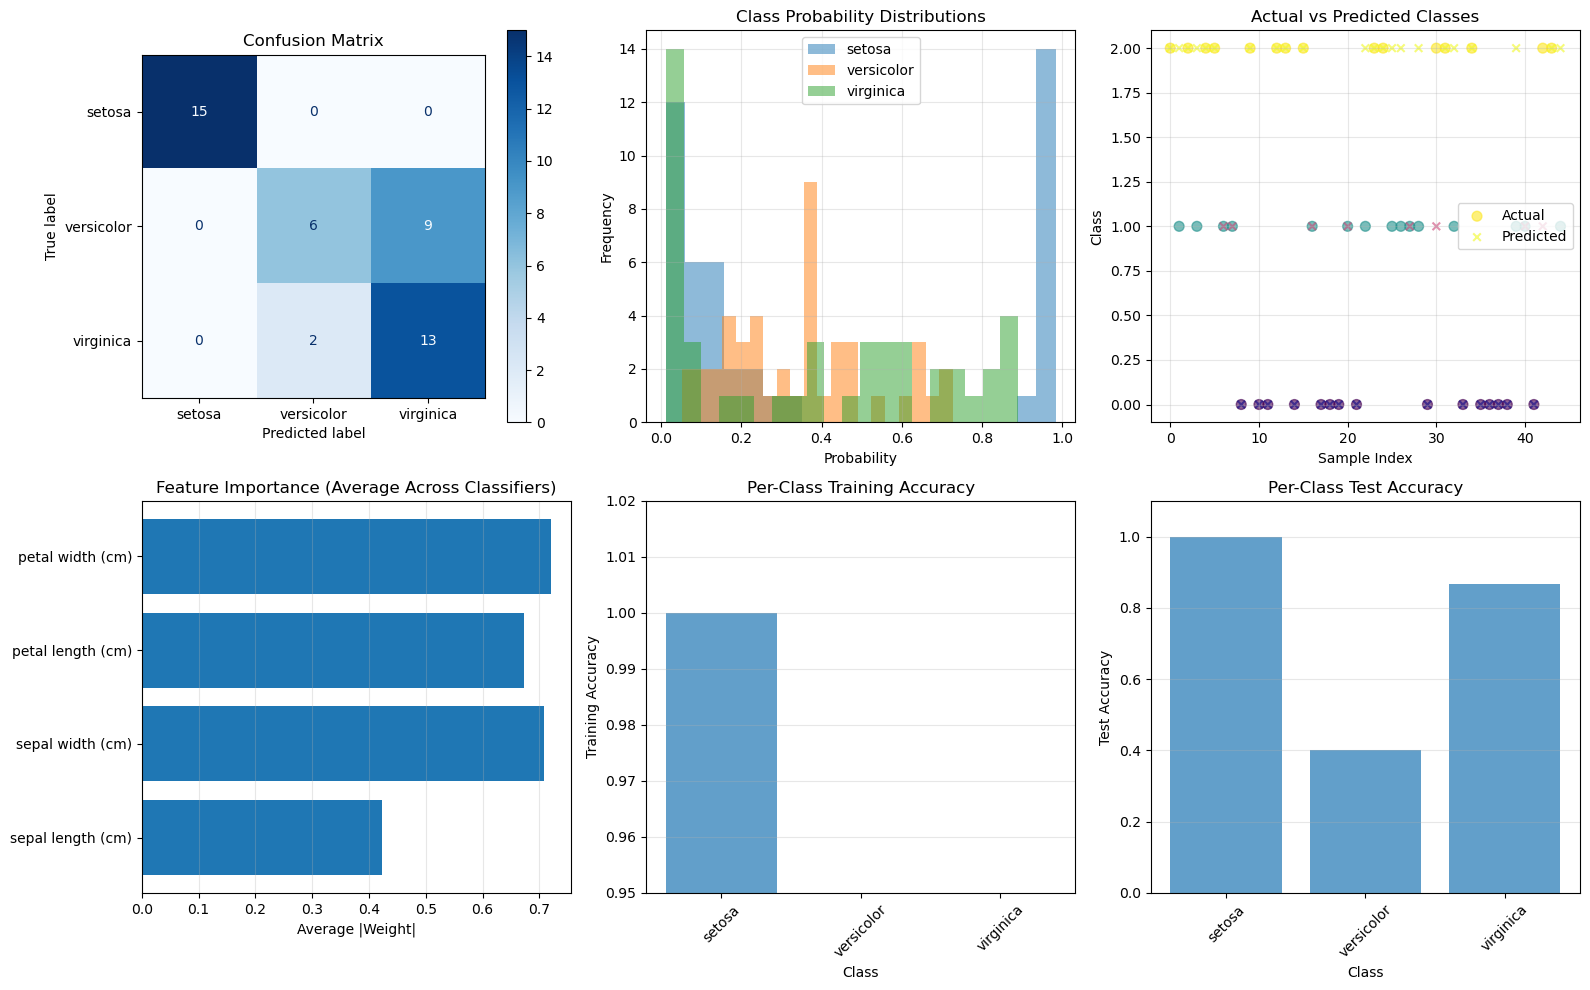


Summary

One-vs-Rest Strategy:
  • Number of binary classifiers trained: 3
  • Each classifier: Class X vs All Other Classes
  • Prediction method: Maximum probability across classifiers

Results:
  • Overall Test Accuracy: 0.7556
  • Classes: setosa, versicolor, virginica

Key Concepts:
  • One-vs-Rest (OvR): Train one binary classifier per class
  • Each classifier distinguishes one class from all others
  • Final prediction: Class with highest probability

✓ Q4 Analysis Complete!


In [13]:
"""
Q4: Multiclass Logistic Regression using One-vs-Rest Strategy
Step-by-step implementation on Iris dataset
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("Q4: Multiclass Logistic Regression using One-vs-Rest Strategy")
print("="*70)

# Load Iris dataset
print("\n1. Loading Iris dataset...")
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print(f"   Dataset shape: {X.shape}")
print(f"   Number of classes: {len(np.unique(y))}")
print(f"   Classes: {target_names}")
print(f"   Features: {feature_names}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"\n2. Split data: Train={X_train.shape[0]}, Test={X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("   ✓ Features scaled")

# Add bias term
X_train_bias = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test_bias = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

print("\n" + "="*70)
print("Step-by-Step Implementation: Binary Logistic Regression")
print("="*70)

def sigmoid(z):
    """Sigmoid activation function"""
    # Clip z to prevent overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def binary_logistic_regression(X, y, lr=0.01, n_iters=1000, tolerance=1e-8):
    """
    Binary Logistic Regression using Gradient Descent
    
    Parameters:
    -----------
    X : array-like, training features (with bias)
    y : array-like, binary target (0 or 1)
    lr : float, learning rate
    n_iters : int, maximum iterations
    tolerance : float, convergence tolerance
    """
    n, m = X.shape
    weights = np.zeros(m)
    
    for i in range(n_iters):
        # Predictions
        z = X.dot(weights)
        h = sigmoid(z)
        
        # Compute gradient
        gradient = X.T.dot(h - y) / n
        
        # Update weights
        weights -= lr * gradient
        
        # Check convergence
        if i > 0:
            cost = -(y.dot(np.log(h + 1e-15)) + (1-y).dot(np.log(1-h + 1e-15))) / n
            if np.linalg.norm(gradient) < tolerance:
                break
    
    return weights

def predict_probability(X, weights):
    """Predict probability using logistic regression"""
    z = X.dot(weights)
    return sigmoid(z)

def predict_class(X, weights, threshold=0.5):
    """Predict binary class"""
    probabilities = predict_probability(X, weights)
    return (probabilities >= threshold).astype(int)

print("\n3. Training binary classifiers for each class using One-vs-Rest strategy...")
print("="*70)

# One-vs-Rest: Train a binary classifier for each class
n_classes = len(np.unique(y_train))
classifiers = []

for class_idx in range(n_classes):
    print(f"\nTraining Classifier {class_idx + 1}/{n_classes}: {target_names[class_idx]} vs Rest")
    
    # Create binary labels for this class (1 for this class, 0 for all others)
    y_binary = (y_train == class_idx).astype(int)
    
    # Train binary logistic regression
    weights = binary_logistic_regression(X_train_bias, y_binary, lr=0.01, n_iters=1000)
    classifiers.append(weights)
    
    # Evaluate on training set
    train_pred = predict_class(X_train_bias, weights)
    train_acc = accuracy_score(y_binary, train_pred)
    print(f"   Training Accuracy: {train_acc:.4f}")

print("\n" + "="*70)
print("4. Making Predictions using One-vs-Rest Strategy")
print("="*70)

def predict_multiclass_ovr(X, classifiers, strategy='max_probability'):
    """
    Predict multiclass using One-vs-Rest strategy
    
    Parameters:
    -----------
    X : array-like, features with bias
    classifiers : list of weights for each class
    strategy : 'max_probability' or 'vote'
    """
    n_samples = X.shape[0]
    n_classes = len(classifiers)
    
    if strategy == 'max_probability':
        # Get probability for each class
        probabilities = np.zeros((n_samples, n_classes))
        for i, weights in enumerate(classifiers):
            probabilities[:, i] = predict_probability(X, weights)
        
        # Predict class with highest probability
        predictions = np.argmax(probabilities, axis=1)
        
    elif strategy == 'vote':
        # Get binary predictions from each classifier
        votes = np.zeros((n_samples, n_classes))
        for i, weights in enumerate(classifiers):
            votes[:, i] = predict_class(X, weights)
        
        # If no votes (all 0), use max probability as fallback
        probabilities = np.zeros((n_samples, n_classes))
        for i, weights in enumerate(classifiers):
            probabilities[:, i] = predict_probability(X, weights)
        
        row_sums = votes.sum(axis=1)
        no_votes = (row_sums == 0)
        
        predictions = np.argmax(votes, axis=1)
        predictions[no_votes] = np.argmax(probabilities[no_votes], axis=1)
    
    return predictions, probabilities

# Make predictions
y_pred, probabilities = predict_multiclass_ovr(X_test_bias, classifiers, strategy='max_probability')

print("\n" + "="*70)
print("5. Model Evaluation")
print("="*70)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\n" + "="*70)
print("6. Visualizations")
print("="*70)

fig = plt.figure(figsize=(16, 10))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')

# 2. Probability distribution for each class
plt.subplot(2, 3, 2)
for i in range(n_classes):
    plt.hist(probabilities[:, i], bins=20, alpha=0.5, label=f'{target_names[i]}')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Class Probability Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Actual vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(range(len(y_test)), y_test, c=y_test, cmap='viridis', label='Actual', alpha=0.6, s=50)
plt.scatter(range(len(y_pred)), y_pred, c=y_pred, cmap='plasma', marker='x', label='Predicted', alpha=0.6, s=30)
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('Actual vs Predicted Classes')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Feature importance (average absolute weights across all classifiers)
plt.subplot(2, 3, 4)
feature_importance = np.abs(np.array(classifiers))[:, 1:].mean(axis=0)  # Exclude bias term
plt.barh(range(len(feature_names)), feature_importance)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Average |Weight|')
plt.title('Feature Importance (Average Across Classifiers)')
plt.grid(True, alpha=0.3, axis='x')

# 5. Learning curves (if we tracked them)
plt.subplot(2, 3, 5)
for i, class_name in enumerate(target_names):
    y_binary = (y_train == i).astype(int)
    predictions = predict_class(X_train_bias, classifiers[i])
    acc = (predictions == y_binary).mean()
    plt.bar(i, acc, label=class_name, alpha=0.7)
plt.ylabel('Training Accuracy')
plt.xlabel('Class')
plt.title('Per-Class Training Accuracy')
plt.xticks(range(n_classes), target_names, rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([0.95, 1.02])

# 6. Test accuracy by class
plt.subplot(2, 3, 6)
class_accuracies = []
for i, class_name in enumerate(target_names):
    mask = y_test == i
    if mask.sum() > 0:
        class_acc = (y_pred[mask] == y_test[mask]).mean()
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)
plt.bar(range(n_classes), class_accuracies, alpha=0.7)
plt.ylabel('Test Accuracy')
plt.xlabel('Class')
plt.title('Per-Class Test Accuracy')
plt.xticks(range(n_classes), target_names, rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Summary")
print("="*70)
print(f"\nOne-vs-Rest Strategy:")
print(f"  • Number of binary classifiers trained: {n_classes}")
print(f"  • Each classifier: Class X vs All Other Classes")
print(f"  • Prediction method: Maximum probability across classifiers")
print(f"\nResults:")
print(f"  • Overall Test Accuracy: {accuracy:.4f}")
print(f"  • Classes: {', '.join(target_names)}")
print("\nKey Concepts:")
print("  • One-vs-Rest (OvR): Train one binary classifier per class")
print("  • Each classifier distinguishes one class from all others")
print("  • Final prediction: Class with highest probability")
print("\n✓ Q4 Analysis Complete!")
print("="*70)
